In [1]:
## Load relevant R packages.

inLibraries = list('repr','rgeos','rgdal','spdep','gstat','classInt','geoR','GISTools','sp','raster', 'maps','maptools')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}

## Resize plot area.

options(repr.plot.width=15, repr.plot.height=15)

In [2]:
# Because ANOVA indicated a possible correlation between mass and lat/long, 
# that is where I am going with my analysis next.

In [3]:
train_ff <- read.csv('data/results/traintest/meteorite_falls_and_found_train.csv')
train_ff <- subset(train_ff, select = -c(X,X.1) )

test_ff <- read.csv('data/results/traintest/meteorite_falls_and_found_test.csv')
test_ff <- subset(test_ff, select = -c(X,X.1) )

head(train_ff)
head(test_ff)

## Convert data from a "maps" object to a "SpatialPolygonsDataFrame" object
mp <- map('world', fill = TRUE, plot = FALSE)
SP <- map2SpatialPolygons(mp, IDs = mp$names, proj4string = CRS("+proj=longlat +datum=WGS84"))
DATA <- data.frame(seq_len(length(SP)), row.names = names(SP))
world_spdf <- SpatialPolygonsDataFrame(SP, data = DATA)

,id,recclass,mass,fell_or_found,year,latitude,longitude,group,chondrite,type,lvl3,lvl4,lc_sample,weights
,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,11632,L4,633.00,Found,1995,28.69167,13.21967,L,Chondrite,Stony,Ordinary,L,11,0.004857815
2,2320,L6,3200.00,Fell,1803,43.86667,5.38333,L,Chondrite,Stony,Ordinary,L,12,0.497990676
3,10154,H4,0.83,Found,1992,-30.73783,127.95367,H,Chondrite,Stony,Ordinary,H,11,0.004857815
4,11542,Eucrite-mmict,143.00,Found,1994,28.94550,13.06950,Eucrite,Achondrite,Stony,Asteroidal,H-E-D Vesta,11,0.004857815
5,11944,L6,23.60,Found,1991,-30.27467,129.01850,L,Chondrite,Stony,Ordinary,L,11,0.004857815
6,45918,LL6,425.00,Found,2006,20.01352,56.40697,LL,Chondrite,Stony,Ordinary,LL,11,0.004857815


,id,recclass,mass,fell_or_found,year,latitude,longitude,group,chondrite,type,lvl3,lvl4,lc_sample,weights
,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>
1,4,H5,331,Found,1982,26.80000,-105.41667,H,Chondrite,Stony,Ordinary,H,2,0.463225691
2,9,H4,4500,Found,1997,27.23944,29.83583,H,Chondrite,Stony,Ordinary,H,11,0.004857815
3,12,H5,228,Found,1989,27.61667,3.85000,H,Chondrite,Stony,Ordinary,H,14,0.498018660
4,13,H5,145,Found,1989,27.81667,4.03333,H,Chondrite,Stony,Ordinary,H,14,0.498018660
5,16,H3.9/4,561,Found,1989,27.63333,3.96667,H,Chondrite,Stony,Ordinary,H,14,0.498018660
6,17,L5,542,Found,1989,27.51667,3.65000,L,Chondrite,Stony,Ordinary,L,14,0.498018660


In [4]:
# First, let's recreate and normalize the weights column
# This is the world in 1990.

lc1990name <- "data/lc/historic_landcover_hd_1990.asc"
lc1990 <- raster(lc1990name,values=TRUE)

landcover_counts<- freq(lc1990)

total <- 259200

for (i in 1:18){
    lc_weight2 <- (landcover_counts[i,2]/total)*100
    train_ff$weights2[train_ff$lc_sample == landcover_counts[i,1]] <- lc_weight2

}

normalize <- function(x) {
return ((x - min(x)) / (max(x) - min(x)))
}

unique(train_ff$weights2)

train_ff$weights2<-normalize(train_ff$weights2)

unique(train_ff$weights2)

[1]  0.3364198  0.3572531  2.2241512  4.5821759  1.4336420  2.2827932
 [7]  0.5412809  4.0671296  1.0501543  1.8429784  0.3406636 66.3206019
[13]  1.0856481  0.7391975  0.6041667  0.7133488

[1] 0.000000e+00 3.157322e-04 2.860885e-02 6.434506e-02 1.662856e-02
 [6] 2.949758e-02 3.104700e-03 5.653946e-02 1.081675e-02 2.283212e-02
[11] 6.431583e-05 1.000000e+00 1.135467e-02 6.104157e-03 4.057744e-03
[16] 5.712415e-03

In [5]:
# Now to get a sample of 2500 rows using those weights.

set.seed(1234)

train_ff2 <- train_ff[sample(seq_len(nrow(train_ff)),2000,prob=train_ff$weights2),]

head(train_ff2)
dim(train_ff2)

,id,recclass,mass,fell_or_found,year,latitude,longitude,group,chondrite,type,lvl3,lvl4,lc_sample,weights,weights2
,<int>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
2191,23091,LL3.3,24.3,Fell,1919,38.16667,-76.38333,LL,Chondrite,Stony,Ordinary,LL,0,71.3451083,1.00000000
5281,465,H4,9251.0,Fell,1900,50.95000,31.81667,H,Chondrite,Stony,Ordinary,H,2,0.4632257,0.06434506
334,12743,L6,800.0,Fell,1938,52.45000,51.56667,L,Chondrite,Stony,Ordinary,L,2,0.4632257,0.06434506
1304,16878,"Iron, IC",1143000.0,Found,1909,-29.58333,139.90000,Iron IC,Achondrite,Iron,Magmatic,Siderite,2,0.4632257,0.06434506
1218,23973,L6,218.0,Found,1888,33.46667,-82.48333,L,Chondrite,Stony,Ordinary,L,1,0.2972737,0.02949758
4067,23494,H5,1192.7,Found,1976,32.71667,-102.65000,H,Chondrite,Stony,Ordinary,H,2,0.4632257,0.06434506


[1] 2000   15

In [6]:
coordinates(train_ff2)<-~longitude+latitude
proj4string(train_ff2)<- CRS("+proj=aeqd +lon_0=0 +lat_0=0 +datum=WGS84 +units=m +no_defs")

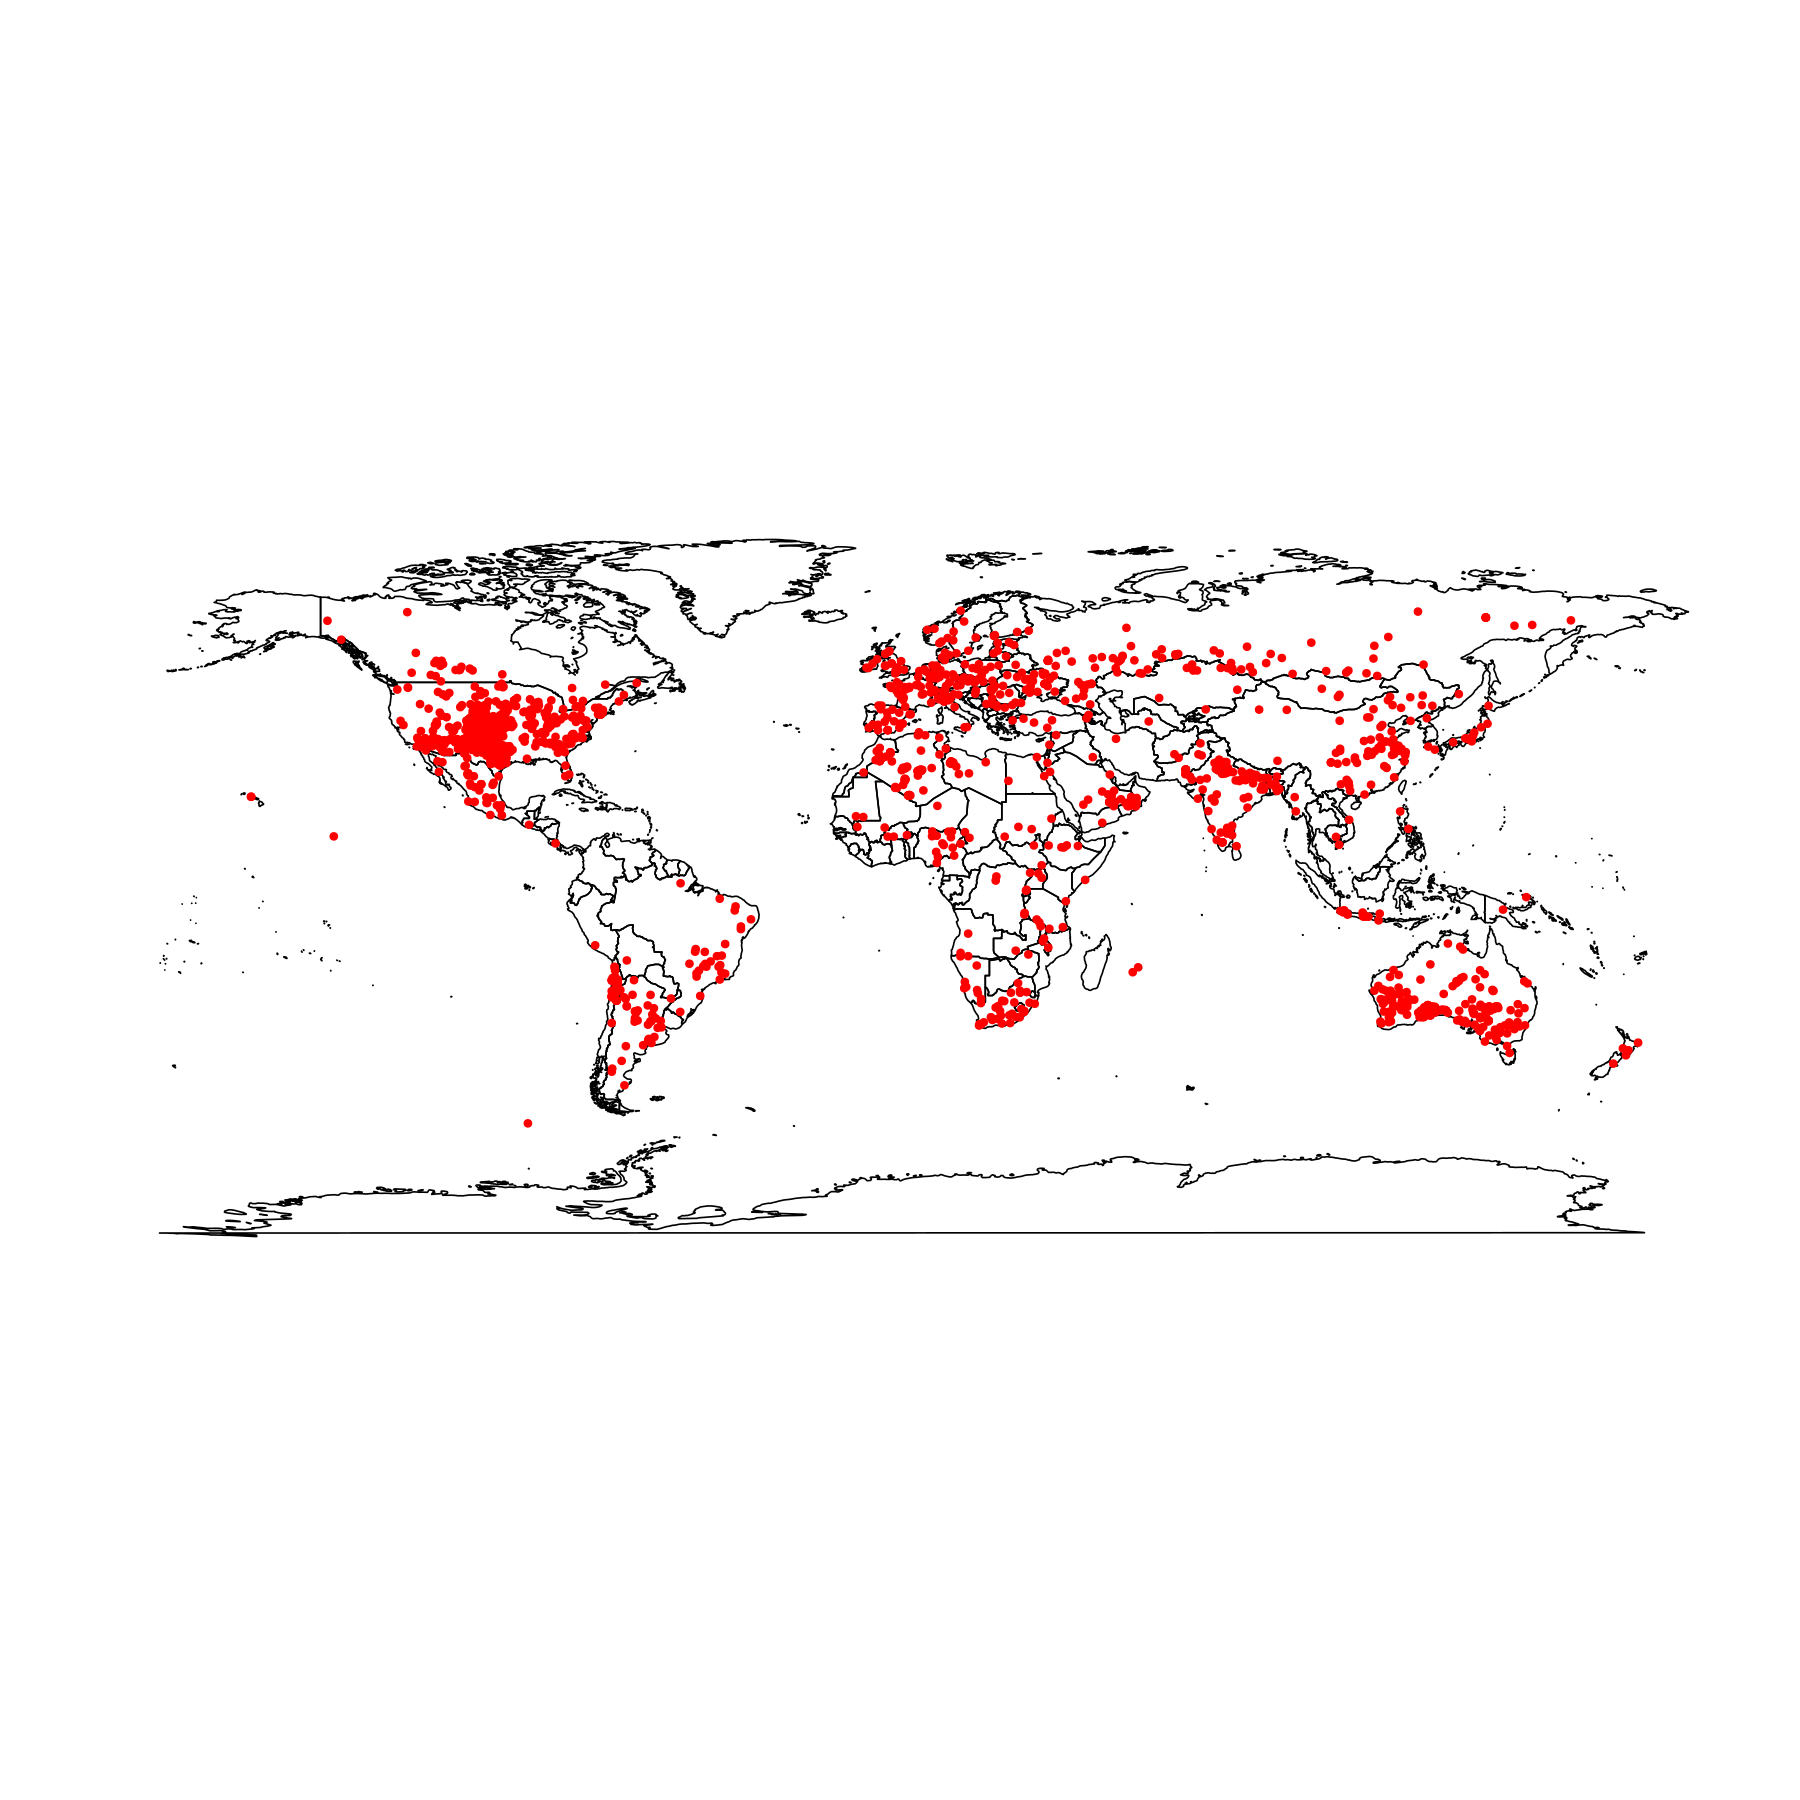

In [7]:
plot(world_spdf)
plot(train_ff2,col="red",pch=20,add=TRUE)

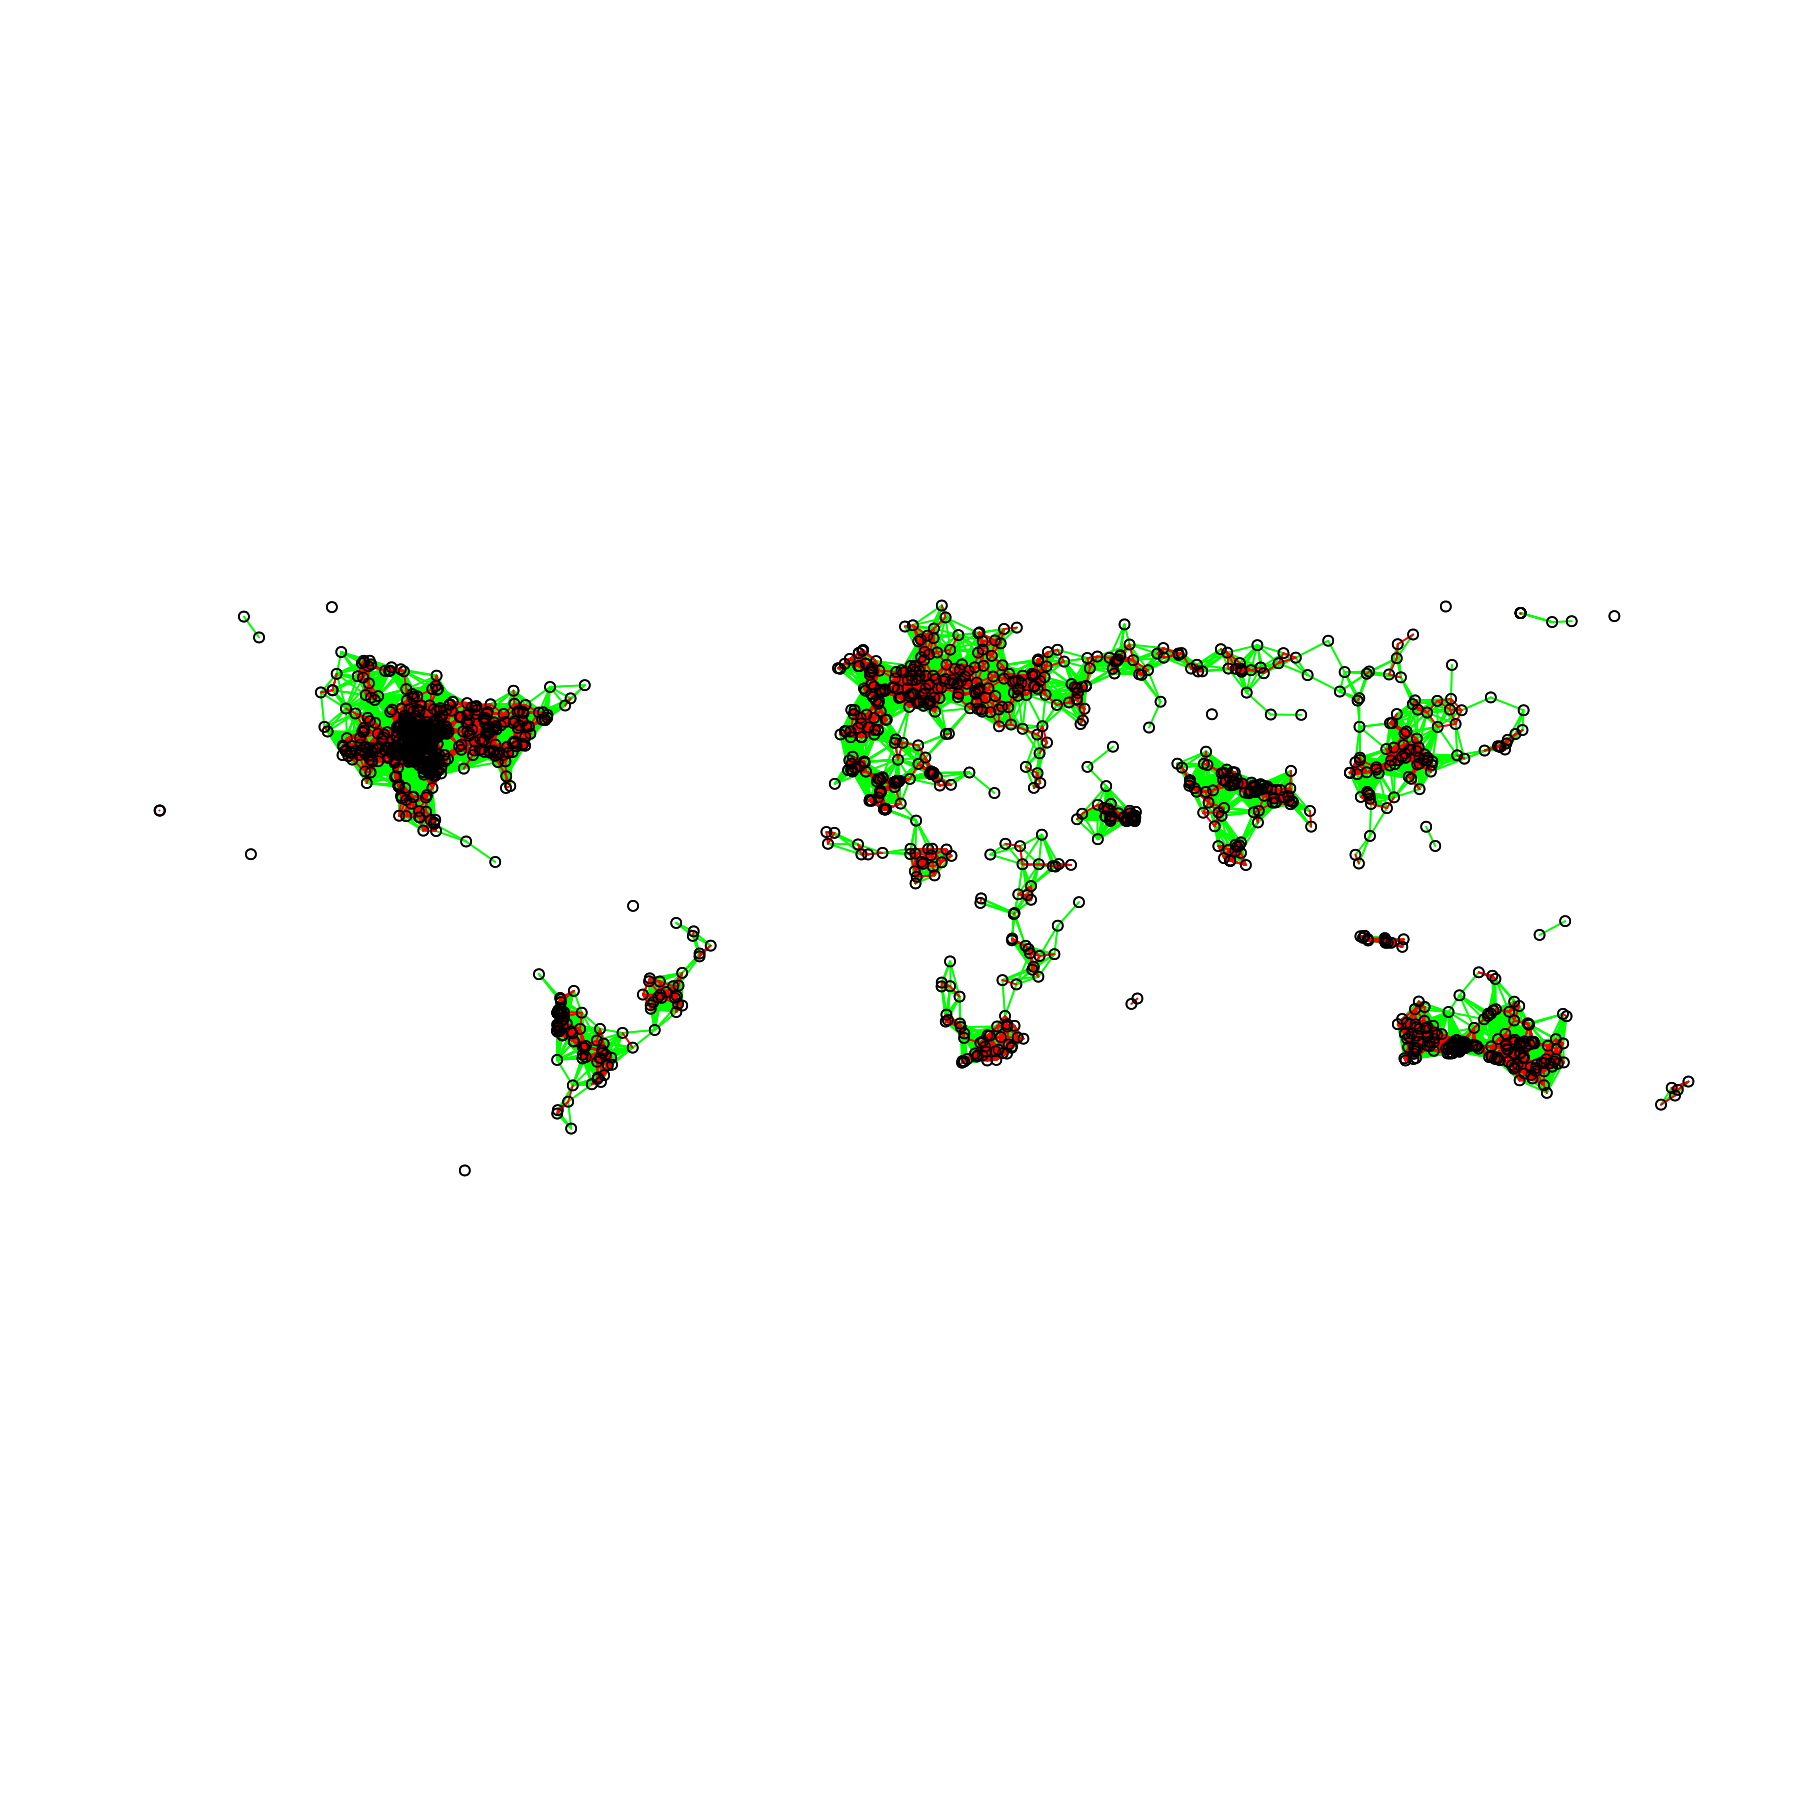

In [41]:
## Nearest Neighbor Analysis

dataset1 <- train_ff2

## Identify the neighbors of each point.

##  0.002 decimal degrees is approximately 200 meters.... depending on where on the earth you are, of course.

#  0.002 dd     1609 m
# ---------- x--------- =  0.01609 dd/mile
#  200 m        1 mile

d2miles <- 250
d3miles <- 500

d1 <- 0
d2 <- d2miles * 0.01609
d3 <- d3miles * 0.01609

coords <- coordinates(dataset1)[,1:2]

dataset1.nb <- dnearneigh(coords,d1,d2,bounds=c("GE", "LT"))
dataset1.2nb <- dnearneigh(coords,d2,d3,bounds=c("GE", "LT"))

plot(dataset1.2nb, coords, col="green",main="Impact 1st and 2nd order Neighbors (Approx. 250 and 500 miles)",cex.main=.8)
plot(dataset1.nb, coords, add=TRUE, col="red")



In [14]:
#

longmin <- min(coordinates(train_ff2)[,1])
longmax <- max(coordinates(train_ff2)[,1])
latmin  <- min(coordinates(train_ff2)[,2])
latmax  <- max(coordinates(train_ff2)[,2])

## Create a grid object

spatialResolution <- 100000000000
gridList <- list()
outGridPolyName <- c()
iter <- 1

grd <- expand.grid(Longitude = seq(from = longmin, to = longmax), Latitude = seq(from = latmin,to = latmax))
coordinates(grd) <- ~Longitude + Latitude
gridded(grd) <- TRUE
proj4string(grd) <- proj4string(train_ff2)
gridList[[iter]] <- grd
grid.poly <- as.SpatialPolygons.GridTopology(grd@grid, proj4string=grd@proj4string)
dLen <- length(grid.poly@polygons)
df.dim <- matrix(nrow=dLen, ncol=1)
df <- data.frame(id=df.dim)
df$id <- c(1:dLen)
rownames(df) <- sapply(slot(grid.poly, 'polygons'), function(x) slot(x,'ID'))
grid.poly <- SpatialPolygonsDataFrame(Sr=grid.poly, data=df, match.ID=T)
rownames(grid.poly@data) <- c(1:dLen)
for (i in 1:dLen){grid.poly@polygons[[i]]@ID <- as.character(i-1)}
grid.poly$pid <- grid.poly$id
outGridPolyName <- c(outGridPolyName, c(grid.poly))
                           
grid1_l <- length(outGridPolyName[[1]])
                           
paste0("Grid contains ",grid1_l," polygons.")

plot(world_spdf)
plot(grd)
plot(train_ff2,col="red",pch=20,add=TRUE)


Warning message in proj4string(train_ff2):
“CRS object has comment, which is lost in output”


[1] "Grid contains 42000 polygons."

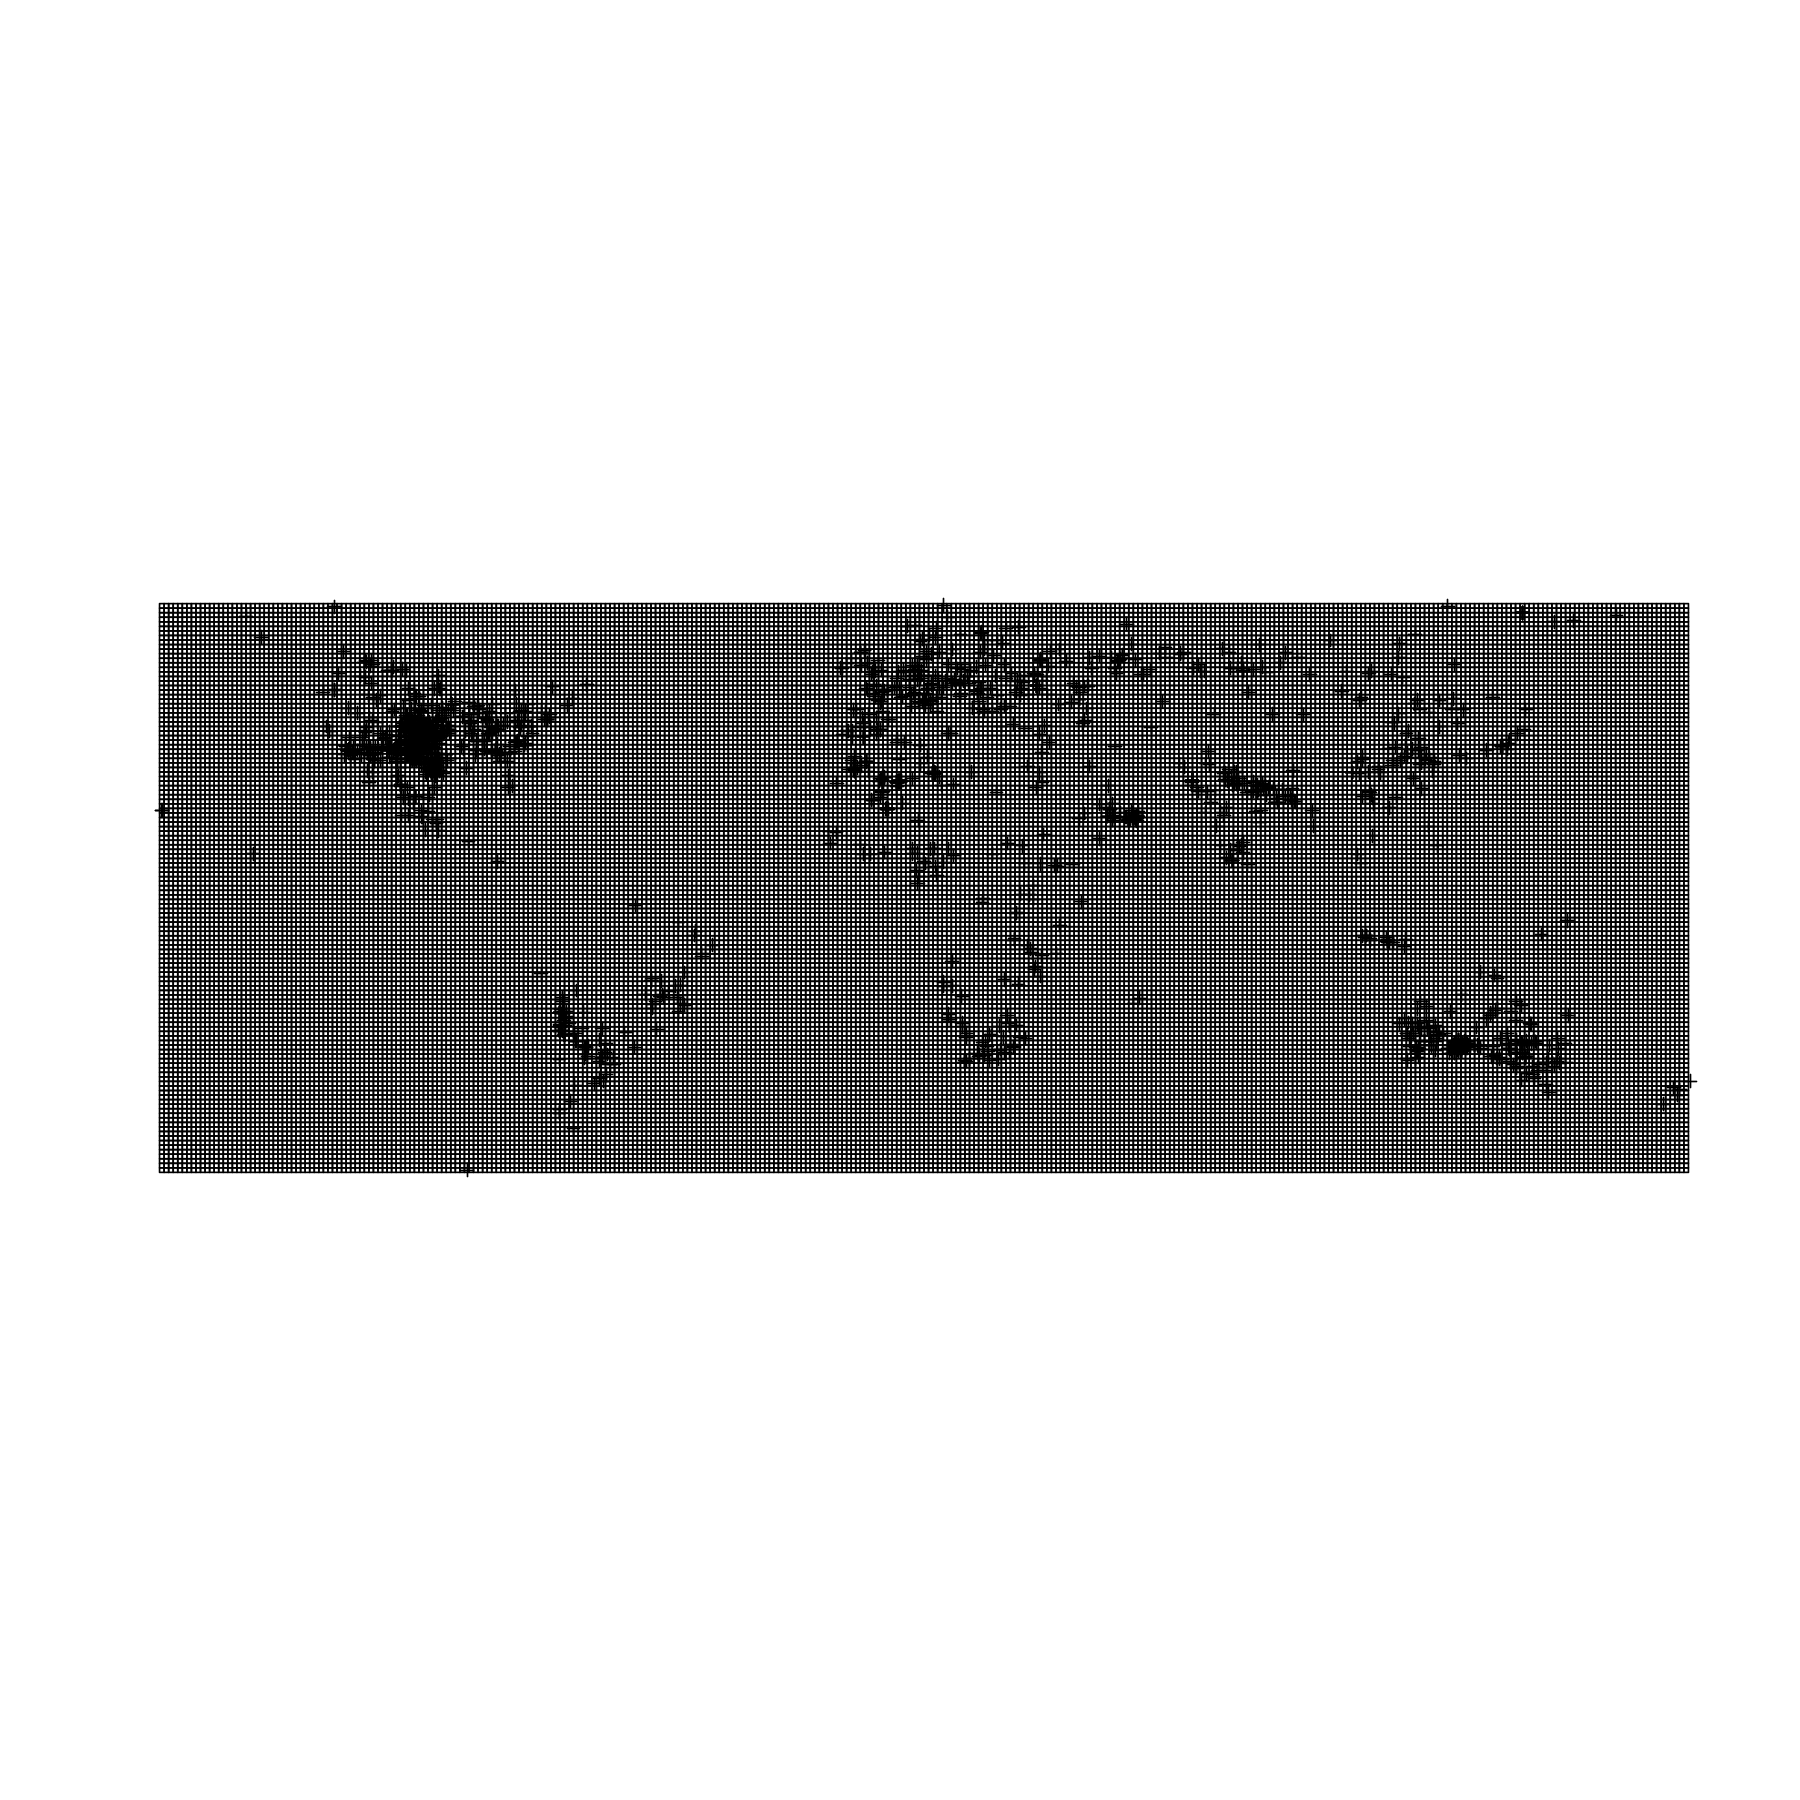

In [19]:
plot(outGridPolyName[[1]])
plot(train_ff2, add=TRUE)  

In [20]:
outPList <- c()
par(mfrow=c(1,3))

train_ff2@data$impactcnt <- 1

iter <- 1

    outGridPolyName[[iter]]@data$uniqueid <- seq.int(nrow(outGridPolyName[[iter]]@data))
    impact.int <- over(train_ff2,outGridPolyName[[iter]])
    train_ff2$utrackid <- impact.int$uniqueid
    retainedVariables <- c("impactcnt","utrackid")
    polyevents <- train_ff2@data[retainedVariables]
    polyevents[] <- lapply(polyevents,function(x) type.convert(as.character(x)))
    aggregateevents <- aggregate(polyevents,by=list(polyevents$utrackid),FUN=sum)
    BPolys <- merge(outGridPolyName[[iter]]@data,aggregateevents,
    by.x="uniqueid",by.y="Group.1",all=TRUE)
    orderedPolys <- BPolys[order(BPolys$uniqueid),]
    outGridPolyName[[iter]]@data$impactsPerPolygon <- orderedPolys$impactcnt
    outPList <- c(outPList,c(outGridPolyName[[iter]]))

head(outPList[[1]]@data)

,id,pid,uniqueid,impactsPerPolygon
,<int>,<int>,<int>,<int>
1,1,1,1,NA
2,2,2,2,NA
3,3,3,3,NA
4,4,4,4,NA
5,5,5,5,NA
6,6,6,6,NA


In [26]:
unique(outPList[[1]]@data$impactsPerPolygon)

[1] NA  1  6  2  3  7  5  4  9  8 10 11 74 17 37 23 15 30 33 50 12 14

Warning message in classIntervals(outPList[[1]]@data$impactsPerPolygon, 7, style = "kmeans"):
“var has missing values, omitted in finding classes”


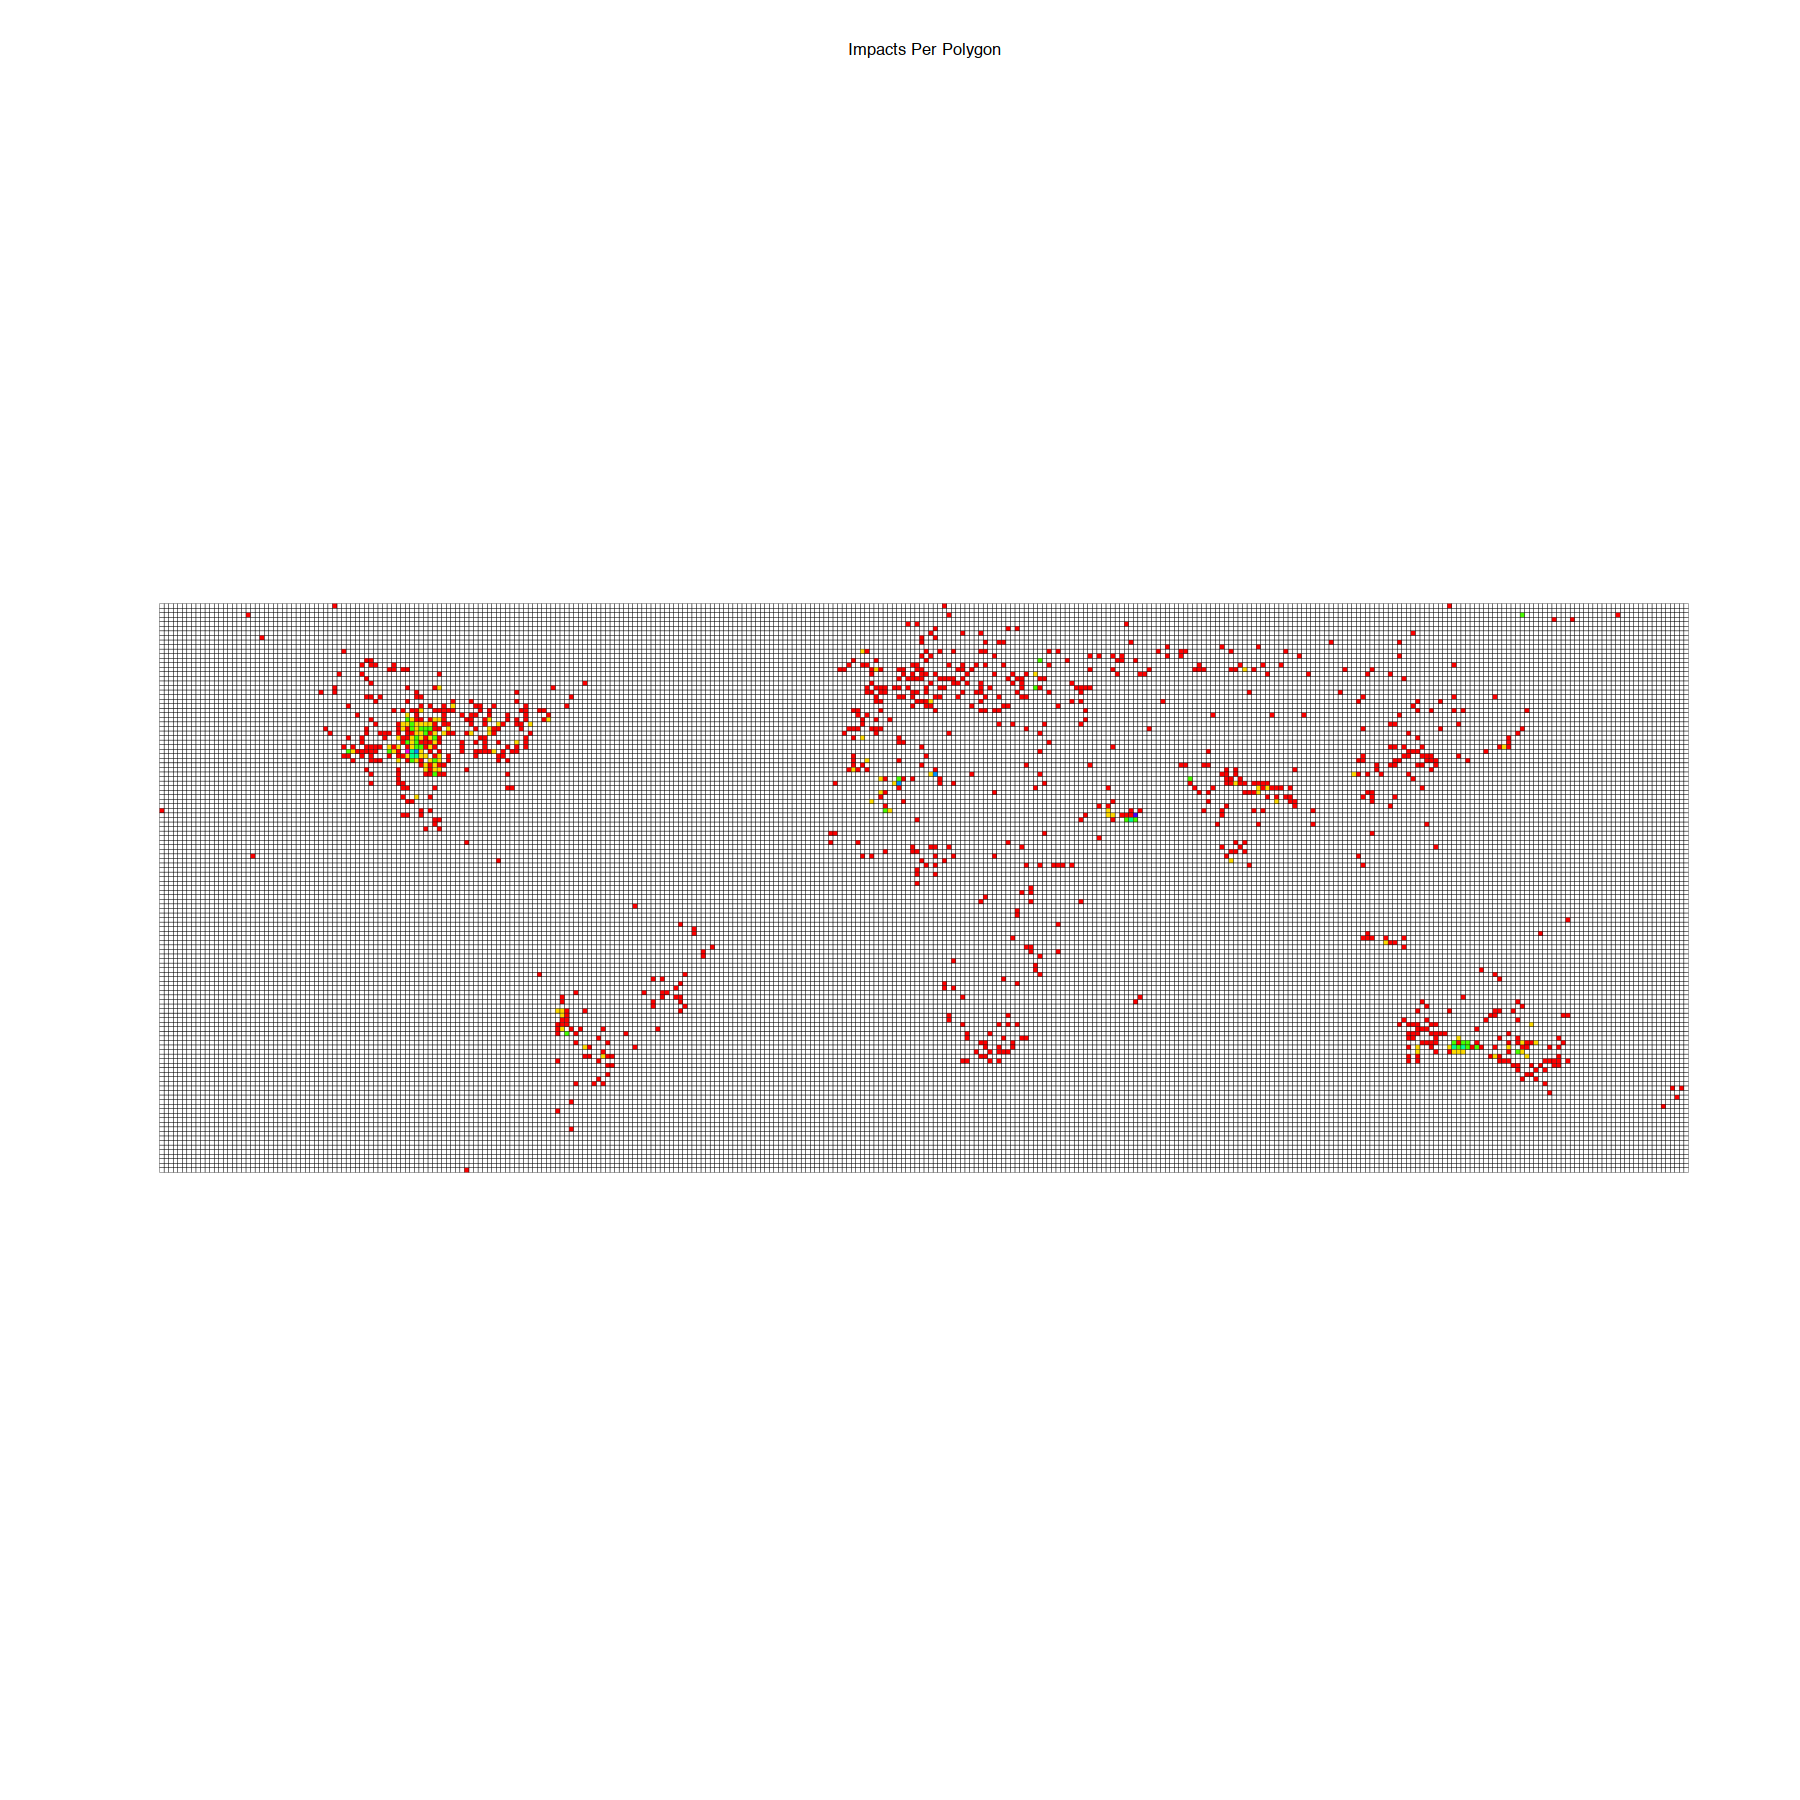

In [29]:
cate <- classIntervals(outPList[[1]]@data$impactsPerPolygon, 7, style="kmeans")


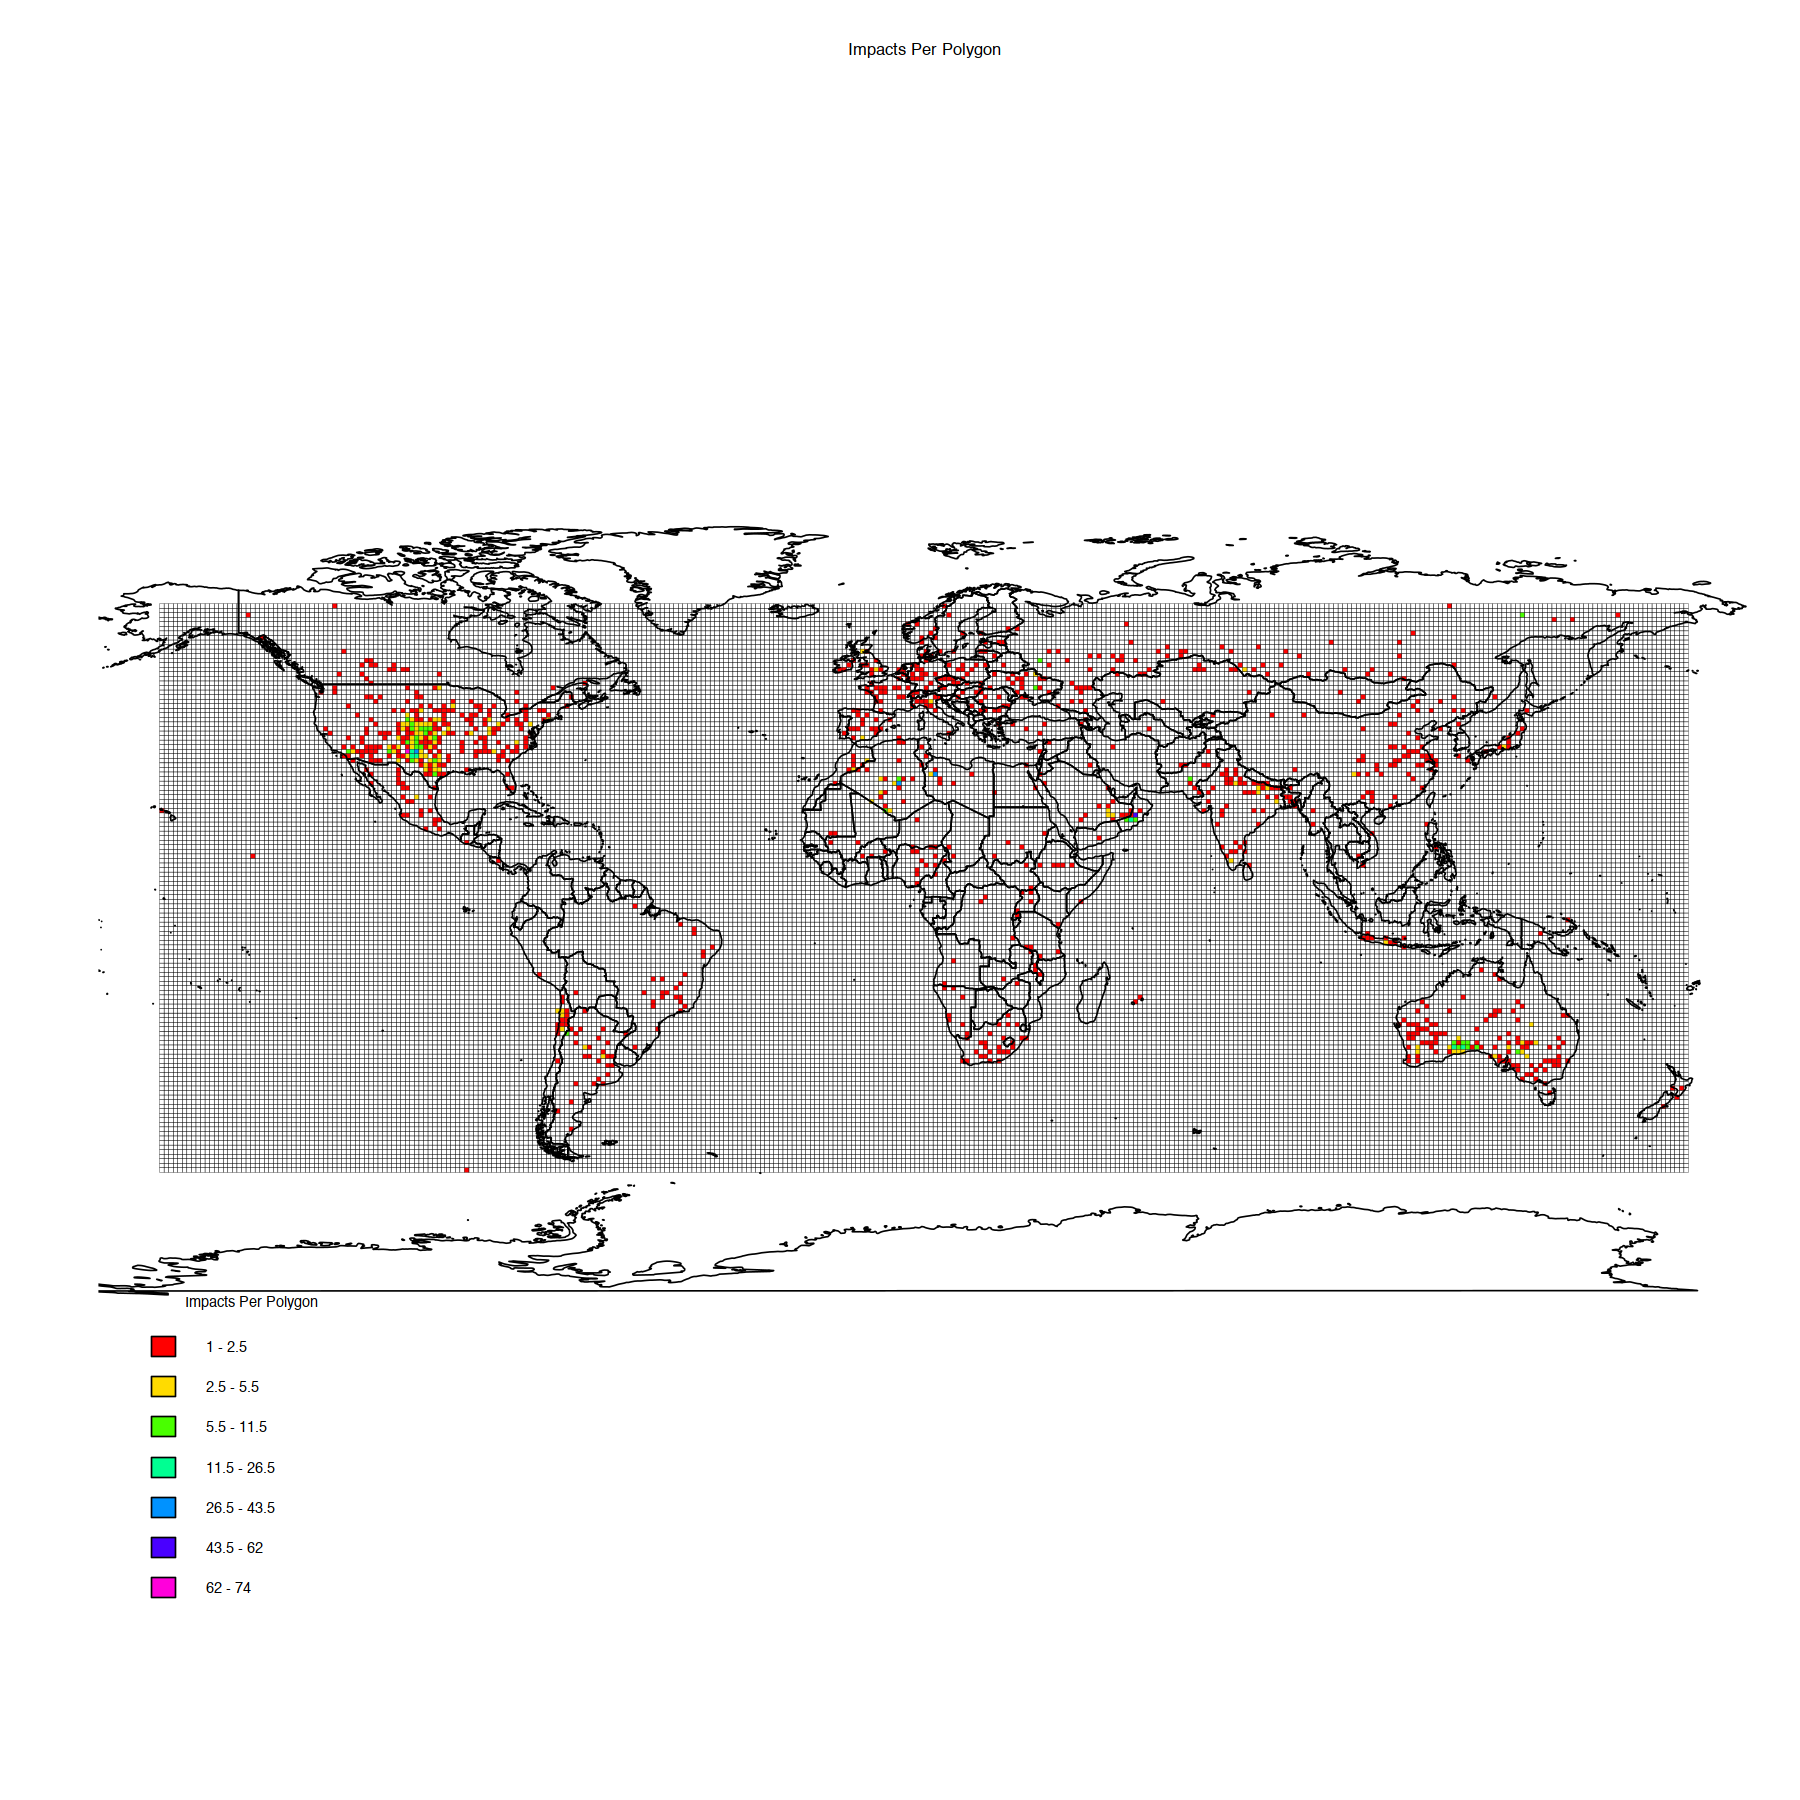

In [32]:
#assign colors to categories
pal <- rainbow(numcat)
cols <- findColours(cate,pal)

plot(outPList[[1]],col=cols,lwd=.2,main="Impacts Per Polygon",cex=4, cex.main=0.8)
brks <- round(cate$brks,3)
plot(world_spdf,add=TRUE)

leg.text <- paste(brks[-(numcat+1)], brks[-1], sep=" - ")

legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Impacts Per Polygon",cex=.7)


In [62]:
#Moran I test on polygons.

inFeatures <- na.exclude(outPList[[1]])
inVa <- inFeatures$impactsPerPolygon
inFeatures.nb <- poly2nb(inFeatures,queen=TRUE)
inFeatures.listb <- nb2listw(inFeatures.nb,style="B")
inFeatures.listw <- nb2listw(inFeatures.nb,style="W")
Mtest <- moran.test(inVa, inFeatures.listb,randomisation='TRUE',alternative='two.sided')
Mtest

ERROR: Error in na.fail.default(x): missing values in object


In [ ]:
## Produce Moran scatterplot.
moran.plot(inVa, inFeatures.listb,labels=as.character(inFeatures$FID),pch=20,
           xlab="Analysis Variable",ylab="Spatially Lagged Analysis Variable",main="Moran Scatterplot - Configuration A",cex.main=.8)
